In [1]:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, \
                            median_absolute_error, mean_absolute_percentage_error
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import itertools

import warnings
warnings.filterwarnings("ignore")

def calcError(y_test, y_pred):
#     R2 = r2_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = sqrt(MSE)
    MAE = mean_absolute_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
#     print(f'R2: {round(R2,4)}')
    print(f'Mean Squared Error: {round(MSE,4)}')
    print(f'Root Mean Sqarred Error: {round(RMSE,4)}')
    print(f'Mean Absolute Error: {round(MAE,4)}')
    print(f'Mean Absolute Percentage Error: {round(MAPE*100,4)}')
    return

In [2]:
# creazione dataframe

data = pd.read_csv('https://www.lombacovid.it/story.csv',usecols = ['data','perc_story','ospedalizzati_story'])

data['data'] = pd.to_datetime(data['data'], dayfirst=True)

data.rename(columns = {'ospedalizzati_story':'ospedalizzati_oggi',
                       'perc_story':'perc_oggi',
                       'data':'date'},
                            inplace = True)

data.set_index('date',inplace=True)

# perc_oggi smoothed by running average of 7 days
running_average = 7     
data['perc_oggi'] = data['perc_oggi'].rolling(window=running_average).mean()
data = data.dropna()

data = data[data.index <= '2022-09-03']

data.tail(10)

,perc_oggi,ospedalizzati_oggi
date,,
2022-08-28,14.705714,694.0
2022-08-29,14.742857,688.0
2022-08-30,14.430000,680.0
2022-08-31,14.257143,655.0
2022-09-01,14.020000,627.0
2022-09-02,13.755714,609.0
2022-09-03,13.324286,600.0
2022-09-04,12.841429,582.0
2022-09-05,12.290000,588.0


In [ ]:
# "manual" loop in order to search the best combination of feature selection 

feat_extr_diz = {
                'dayofweek':data.index.dayofweek,
                'quarter':data.index.quarter,
#                  'dayofyear':data.index.dayofyear,
                 'day':data.index.day,
                 'weekofyear':data.index.weekofyear,
#                  'daysinmonth':data.index.daysinmonth,
                 'month':data.index.month,
#                  'year':data.index.year
}

error = {}

stuff = feat_extr_diz.keys()
number = 1
for L in range(len(stuff) + 1):
    for subset in itertools.combinations(stuff, L):
        print(f'\n________________\nnew subset training n {number}: ')
        data_loop = data.copy()
        for i in list(subset):    
            data_loop[i] = feat_extr_diz[i]
            
        print(list(data_loop.drop('ospedalizzati_oggi',axis=1).columns))
        print()
        
        # perc shifted by 7 d in future
        data_loop.perc_oggi = data_loop.perc_oggi.shift(7).fillna(method='bfill')

        # y ospedalizzati
        series = data_loop.ospedalizzati_oggi

        # splitting test and train
        len_train_train_test = int(len(series.index)-len(series.index)*10/100)
        index_train_test = list(data_loop.index)[len_train_train_test]

        # y test and y train
        y_train = series[series.index <= index_train_test]
        y_test = series[series.index > index_train_test]

        # X exog df
        exog_col = list(data_loop.drop('ospedalizzati_oggi',axis=1).columns)  
        exogen_train = data_loop[exog_col][data_loop.index <= index_train_test]
        exogen_test = data_loop[exog_col][data_loop.index > index_train_test]
        
        # prediction df after training
        df_exog_prediction = data_loop[exog_col][data_loop.index >= data_loop.index[-7]].reset_index(drop=True)
        df_exog_prediction['date'] = pd.date_range(start=exogen_test.index[-1]+timedelta(1),periods=7,freq='D')
        df_exog_prediction.set_index('date',inplace=True)
    
    
    
    
        # -> SARIMAX Model train/test
        sxmodel = pm.auto_arima(y_train.values.reshape(-1, 1), 
                                    exogenous = exogen_train.values.reshape(-1,len(exog_col)),
                                    start_p=1, start_q=1, d=None,
                                    max_p=5, max_q=5,
                                    start_P=0, start_Q=0, D=None,
                                    seasonal=True,
                                    m = 7,
                                    test='adf',
                                    n_jobs=-1,
                                    trace=False,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=True)


        # Forecast
        n_periods = len(y_test)
        fitted_values, confint = sxmodel.predict(n_periods=n_periods, 
                                              exogenous = exogen_test.values.reshape(-1,len(exog_col)), 
                                              return_conf_int=True)
        index_of_fc = pd.date_range(y_test.index[1], periods = n_periods, freq='D')

            # make series for plotting purpose
        fitted_series_test = pd.Series(fitted_values, index=index_of_fc)

        # Plot
        plt.figure(figsize=(10,6))
        plt.plot(y_test,label='test set')
        plt.plot(fitted_series_test, color='darkgreen',label='forecasting set')
        plt.legend()
        title = "Final Forecast SARIMAX - exog var: " + str(number)
        plt.title(title)
        plt.show()
        
        # error
        print('Error on test SARIMAX - exog var: ' + str(list(data_loop.drop('ospedalizzati_oggi',axis=1).columns)))
        calcError(y_test,fitted_series_test)
            
        # df
        display(data_loop)


        RMSE = sqrt(mean_squared_error(y_test, fitted_series_test))
        MAPE = mean_absolute_percentage_error(y_test, fitted_series_test)
        
        error[number]= [round(RMSE,4),
                        str(list(data_loop.drop('ospedalizzati_oggi',axis=1).columns)),
                        round(MAPE,4)]
        
        number = number + 1
              


In [ ]:
result_error = pd.DataFrame(error.values(),index=error.keys())
result_error.sort_values(by=0,ascending=True)

In [ ]:
result_error.sort_values(by=2,ascending=True)

In [3]:
# -> best model rmse: ['perc_oggi', 'day', 'weekofyear', 'month']
# -> best model mape: ['perc_oggi', 'day', 'weekofyear', 'month']

def timeserieFeatureExtractor_best(timeseries):
    timeseries['day'] = timeseries.index.day
    timeseries['weekofyear'] = timeseries.index.weekofyear
    timeseries['month'] = timeseries.index.month
    timeseries.fillna(0,inplace=True)
    return 

# creazione dataframe

data = pd.read_csv('https://www.lombacovid.it/story.csv',usecols = ['data','perc_story','ospedalizzati_story'])

data['data'] = pd.to_datetime(data['data'], dayfirst=True)

data.rename(columns = {'ospedalizzati_story':'ospedalizzati_oggi',
                       'perc_story':'perc_oggi',
                       'data':'date'},
                            inplace = True)

data.set_index('date',inplace=True)


# perc_oggi smoothed by running average of 7 days
running_average = 7     
data['perc_oggi'] = data['perc_oggi'].rolling(window=running_average).mean()
data = data.dropna()

# exog df for prediction
exog_df = pd.DataFrame(data.perc_oggi[data.index >= data.index[-7]])
# exog_df.reset_index(inplace=True)
exog_df['date'] = pd.date_range(start= exog_df.index[-1]+timedelta(days=1),periods=7)
exog_df.set_index('date',inplace=True)

# perc shifted by 7 d in future
data.perc_oggi = data.perc_oggi.shift(7).fillna(method='bfill')
    
timeserieFeatureExtractor_best(data)
timeserieFeatureExtractor_best(exog_df)

# y ospedalizzati
series = data.ospedalizzati_oggi
exog_series = data.drop('ospedalizzati_oggi',axis=1)


# splitting test and train
len_train_train_test = int(len(series.index)-len(series.index)*10/100)
index_train_test = list(data.index)[len_train_train_test]

# y test and y train
y_train = series[series.index <= index_train_test]
y_test = series[series.index > index_train_test]

# X exog df
exog_col = list(data.drop('ospedalizzati_oggi',axis=1).columns)  
exogen_train = data[exog_col][data.index <= index_train_test]
exogen_test = data[exog_col][data.index > index_train_test]

# prediction df after training
df_exog_prediction = data[exog_col][data.index >= data.index[-7]].reset_index(drop=True)
df_exog_prediction['date'] = pd.date_range(start=exogen_test.index[-1]+timedelta(1),periods=7,freq='D')
df_exog_prediction.set_index('date',inplace=True)


In [4]:
best_model = pm.auto_arima(y_train.values.reshape(-1, 1), 
                                    exogenous = exogen_train.values.reshape(-1,len(exog_col)),
                                    start_p=1, start_q=1, d=None,
                                    max_p=5, max_q=5,
                                    start_P=0, start_Q=0, D=None,
                                    seasonal=True,
                                    m = 7,
                                    test='adf',
                                    n_jobs=-1,
                                    trace=True,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=7105.606, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=7649.433, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=7135.701, Time=1.48 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=7305.850, Time=1.37 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=7648.227, Time=0.37 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=7113.815, Time=1.46 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=7132.861, Time=1.89 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=7433.448, Time=0.87 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=7208.882, Time=0.61 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=7112.777, Time=1.05 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=7163.524, Time=0.94 sec
 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=7353.068, Time=0.84 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=7167.212, Time=0.94 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : 

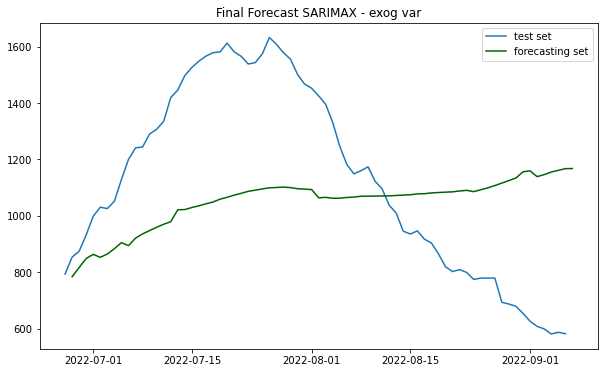

Error on test SARIMAX - exog var: 
Mean Squared Error: 131421.5075
Root Mean Sqarred Error: 362.521
Mean Absolute Error: 319.8308
Mean Absolute Percentage Error: 31.4205


In [5]:
# Forecast
n_periods = len(y_test)
fitted_values, confint = best_model.predict(n_periods=n_periods, 
                                              exogenous = exogen_test.values.reshape(-1,len(exog_col)), 
                                              return_conf_int=True)
index_of_fc = pd.date_range(y_test.index[1], periods = n_periods, freq='D')

# make series for plotting purpose
fitted_series_test = pd.Series(fitted_values, index=index_of_fc)

# Plot
plt.figure(figsize=(10,6))
plt.plot(y_test,label='test set')
plt.plot(fitted_series_test, color='darkgreen',label='forecasting set')
plt.legend()
title = "Final Forecast SARIMAX - exog var"
plt.title(title)
plt.show()

# error
print('Error on test SARIMAX - exog var: ')
calcError(y_test,fitted_series_test)

In [6]:
# -> SARIMAX Model on all ts
sxmodel_all = pm.auto_arima(series.values.reshape(-1, 1), 
                                    exogenous = exog_series.values.reshape(-1,len(exog_series.columns)),
                                    start_p=1, start_q=1, d=None,
                                    max_p=5, max_q=5,
                                    start_P=0, start_Q=0, D=None,
                                    seasonal=True,
                                    m = 7,
                                    test='adf',
                                    n_jobs=-1,
                                    trace=True,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=8239.483, Time=1.18 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=13269.667, Time=0.22 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=13303.412, Time=0.32 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=8079.091, Time=1.66 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=8163.495, Time=2.21 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=8159.540, Time=1.49 sec
 ARIMA(1,0,1)(2,0,1)[7] intercept   : AIC=8283.424, Time=2.74 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(2,0,1)(1,0,0)[7] intercept   : AIC=8102.873, Time=2.38 sec
 ARIMA(1,0,2)(1,0,0)[7] intercept   : AIC=8134.415, Time=1.84 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(0,0,2)(1,0,0)[7] intercept   : AIC=inf, Time=2.62

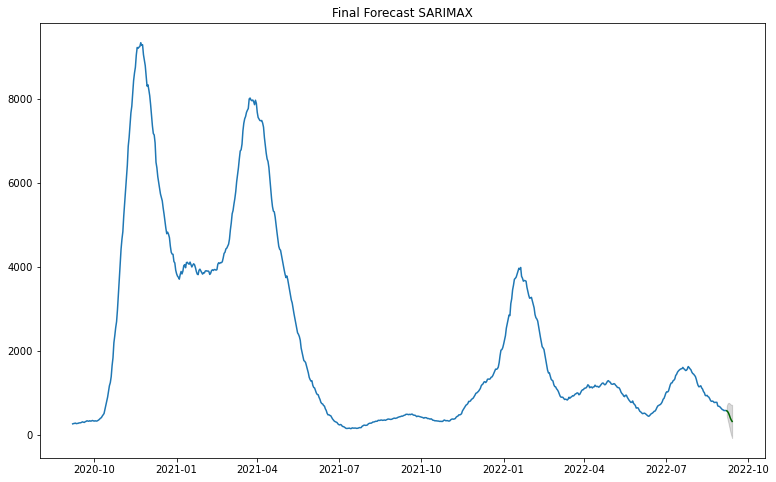

In [7]:
# Forecast
n_periods = 7
fitted_values, confint = sxmodel_all.predict(n_periods=n_periods, 
                                  exogenous=exog_df.values.reshape(-1,len(exog_series.columns)), 
                                  return_conf_int=True)



index_of_fc = pd.date_range(series.index[-1]+timedelta(days=1), periods = n_periods, freq='D')

# make series for plotting purpose
fitted_series = pd.Series(fitted_values, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(13,8))
plt.plot(series)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.title("Final Forecast SARIMAX")
plt.show()

In [8]:
# df prediction of sarimax trained on all data
fitted_series

2022-09-07    578.520665
2022-09-08    560.138328
2022-09-09    522.740923
2022-09-10    468.609871
2022-09-11    406.530980
2022-09-12    359.477101
2022-09-13    325.329191
Freq: D, dtype: float64

In [11]:
with open("results.txt","a") as res:
    res.write('SARIMAX\n')
    for i in range(len(fitted_series)):
        date = str(fitted_series.index[i])
        value = str(round(fitted_series.values[i],4))
        res.write(date+' - '+value+'\n')
    res.write('\n\n')